<a href="https://colab.research.google.com/github/sada1908/githublearnings/blob/main/Final_Auto_Port_Handling_snr_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import zipfile
import os
from sklearn.model_selection import train_test_split


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image


In [4]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [5]:
import cv2
from google.colab.patches import cv2_imshow

In [6]:
import pathlib

In [7]:
from sklearn.metrics import classification_report

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
!unzip -q /content/drive/MyDrive/Automating_Port_Operations_dataset.zip -d /content1/

In [12]:
!ls /content1/Automating_Port_Operations_dataset/

buoy  cruise_ship  ferry_boat  freight_boat  gondola  inflatable_boat  kayak  paper_boat  sailboat


In [13]:
my_img_dir = pathlib.Path('/content1/Automating_Port_Operations_dataset/')

In [14]:
my_img_files = list(my_img_dir.glob(r'*/*'))

In [15]:
my_img_files[0]

PosixPath('/content1/Automating_Port_Operations_dataset/kayak/7.jpg')

In [16]:
labels =[]
labels = [pathlib.Path(path).parent.name for path in my_img_files]


In [17]:
len(my_img_files),len(labels)

(1162, 1162)

In [18]:
my_img_df = pd.DataFrame(my_img_files, columns=['image_path'])
my_img_df['label'] = labels

In [19]:
my_img_df['image_path'] = my_img_df['image_path'].astype(str)

In [20]:
my_img_df.head()

,image_path,label
0,/content1/Automating_Port_Operations_dataset/k...,kayak
1,/content1/Automating_Port_Operations_dataset/k...,kayak
2,/content1/Automating_Port_Operations_dataset/k...,kayak
3,/content1/Automating_Port_Operations_dataset/k...,kayak
4,/content1/Automating_Port_Operations_dataset/k...,kayak


In [21]:
my_img_df['label'].value_counts()

label
sailboat           389
kayak              203
gondola            193
cruise_ship        191
ferry_boat          63
buoy                53
paper_boat          31
freight_boat        23
inflatable_boat     16
Name: count, dtype: int64

In [22]:
X = my_img_df['image_path']
y = my_img_df['label']

In [23]:
label_encoder = LabelEncoder()
X_encoded = label_encoder.fit_transform(X)

In [24]:
# Label encode the target variable
label_encoder_y = LabelEncoder()
y_encoded = label_encoder_y.fit_transform(y)

In [25]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_new, y_new = smote.fit_resample(X_encoded.reshape(-1, 1), y_encoded)

In [26]:
X_inv = label_encoder.inverse_transform(X_new)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [27]:
y_inv = label_encoder_y.inverse_transform(y_new)

In [28]:
new_img_df = pd.DataFrame({'image_path': X_inv, 'label': y_inv})

In [29]:
new_img_df['label'].value_counts()

label
kayak              389
inflatable_boat    389
gondola            389
paper_boat         389
sailboat           389
freight_boat       389
ferry_boat         389
cruise_ship        389
buoy               389
Name: count, dtype: int64

In [30]:
train1_df, test_df = train_test_split(new_img_df, test_size=0.2, random_state=2)

In [31]:
train_df, val_df = train_test_split(train1_df, test_size=0.2, random_state=2)

In [32]:
len(train_df),len(test_df),len(val_df)

(2240, 701, 560)

In [33]:
train_generator = ImageDataGenerator(rescale=1./255,rotation_range=20,
                  width_shift_range=0.2,height_shift_range=0.2,
                  zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
test_generator = ImageDataGenerator(rescale=1./255)
val_generator = ImageDataGenerator(rescale=1./255)

In [34]:
train_generator ,test_generator

(<keras.src.preprocessing.image.ImageDataGenerator at 0x7901b137f490>,
 <keras.src.preprocessing.image.ImageDataGenerator at 0x7901b137f3d0>)

In [35]:
test_data = test_generator.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=28,
    color_mode='rgb'
)

Found 701 validated image filenames belonging to 9 classes.


In [36]:
train_data = train_generator.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=28,
    color_mode='rgb'
)

Found 2240 validated image filenames belonging to 9 classes.


In [37]:
val_data = val_generator.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=28,
    color_mode='rgb'
)

Found 560 validated image filenames belonging to 9 classes.


In [38]:
num_class = len(train_data.class_indices)
num_class

9

In [39]:
def build_cnn_model(input_shape,num_class):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(GlobalAveragePooling2D())
    # model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_class, activation='softmax'))
    return model

input_shape = (224, 224, 3)
num_class = len(train_data.class_indices)
model = build_cnn_model(input_shape, num_class)

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [44]:
history = model.fit(train_data, epochs=50, validation_data=val_data,callbacks=[early_stopping])

Epoch 1/50
70/70 [==============================] - 55s 680ms/step - loss: 2.1999 - accuracy: 0.1129 - val_loss: 2.1938 - val_accuracy: 0.1125
Epoch 2/50
70/70 [==============================] - 42s 601ms/step - loss: 2.1606 - accuracy: 0.1621 - val_loss: 2.0863 - val_accuracy: 0.2089
Epoch 3/50
70/70 [==============================] - 42s 603ms/step - loss: 2.0629 - accuracy: 0.2335 - val_loss: 2.0297 - val_accuracy: 0.2143
Epoch 4/50
70/70 [==============================] - 47s 670ms/step - loss: 2.0121 - accuracy: 0.2571 - val_loss: 2.0406 - val_accuracy: 0.1946
Epoch 5/50
70/70 [==============================] - 42s 601ms/step - loss: 1.9219 - accuracy: 0.2871 - val_loss: 1.9998 - val_accuracy: 0.2750
Epoch 6/50
70/70 [==============================] - 42s 597ms/step - loss: 1.8691 - accuracy: 0.3054 - val_loss: 1.9145 - val_accuracy: 0.3018
Epoch 7/50
70/70 [==============================] - 42s 608ms/step - loss: 1.8033 - accuracy: 0.3388 - val_loss: 1.8487 - val_accuracy: 0.3357

In [45]:
test_loss, test_acc = model.evaluate(test_data)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

22/22 [==============================] - 5s 204ms/step - loss: 1.3390 - accuracy: 0.5307
Test Loss: 1.3390017747879028
Test Accuracy: 0.5306704640388489


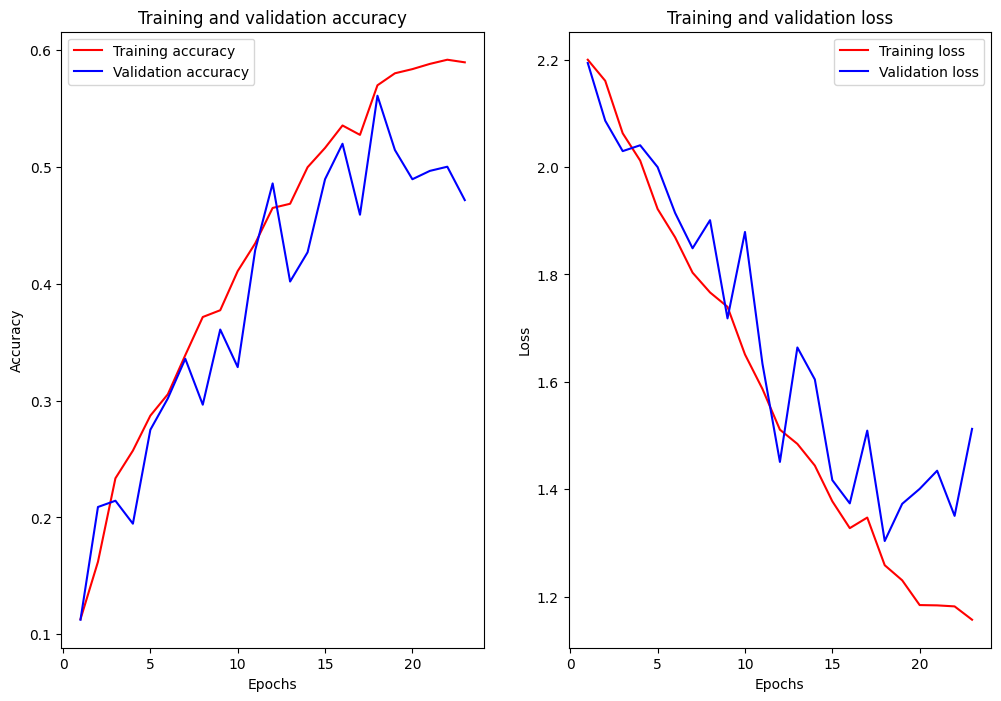

In [46]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the plot_history function
plot_history(history)

In [47]:
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_data.classes, predicted_labels)

22/22 [==============================] - 4s 197ms/step


In [48]:
predicted_labels

array([3, 5, 2, 3, 5, 3, 1, 5, 6, 7, 6, 4, 7, 6, 1, 5, 3, 5, 3, 4, 2, 0,
       3, 3, 8, 4, 0, 3, 1, 3, 6, 4, 6, 0, 4, 7, 4, 7, 5, 1, 1, 7, 7, 5,
       4, 4, 5, 7, 5, 4, 5, 8, 5, 6, 6, 4, 4, 0, 5, 3, 1, 8, 4, 3, 3, 7,
       5, 8, 1, 5, 4, 4, 1, 1, 7, 4, 6, 4, 1, 5, 5, 5, 1, 7, 0, 5, 8, 1,
       3, 7, 4, 4, 7, 4, 5, 1, 1, 4, 0, 4, 2, 1, 8, 5, 5, 1, 1, 7, 4, 7,
       8, 1, 1, 1, 5, 0, 7, 4, 2, 0, 7, 2, 6, 4, 5, 2, 7, 7, 4, 4, 2, 4,
       7, 7, 1, 7, 3, 3, 8, 1, 5, 3, 1, 1, 3, 8, 2, 4, 3, 4, 4, 1, 6, 4,
       5, 1, 1, 3, 5, 2, 3, 3, 8, 7, 3, 1, 1, 3, 5, 4, 5, 4, 4, 3, 4, 4,
       4, 4, 8, 5, 5, 7, 3, 8, 6, 1, 5, 3, 3, 4, 7, 1, 5, 5, 8, 4, 1, 4,
       3, 4, 4, 6, 3, 3, 8, 7, 4, 4, 1, 1, 4, 5, 2, 4, 4, 3, 5, 3, 7, 4,
       0, 1, 3, 0, 4, 4, 5, 3, 0, 4, 6, 4, 3, 5, 0, 7, 5, 2, 4, 8, 8, 1,
       0, 5, 1, 6, 6, 0, 7, 7, 1, 2, 2, 1, 1, 5, 7, 7, 3, 2, 5, 3, 7, 0,
       6, 2, 8, 4, 3, 4, 3, 5, 4, 2, 5, 1, 7, 5, 0, 4, 1, 3, 7, 7, 0, 7,
       4, 4, 3, 3, 8, 1, 1, 3, 4, 1, 3, 1, 4, 5, 5,

In [49]:
# Plot the confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(16,8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    xticks = plt.xticks(rotation=30)
    plt.show()


In [50]:
# Get the class names from the train dataset
class_names = train_data.class_indices.keys()
class_names

dict_keys(['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat'])

<Figure size 1600x800 with 0 Axes>

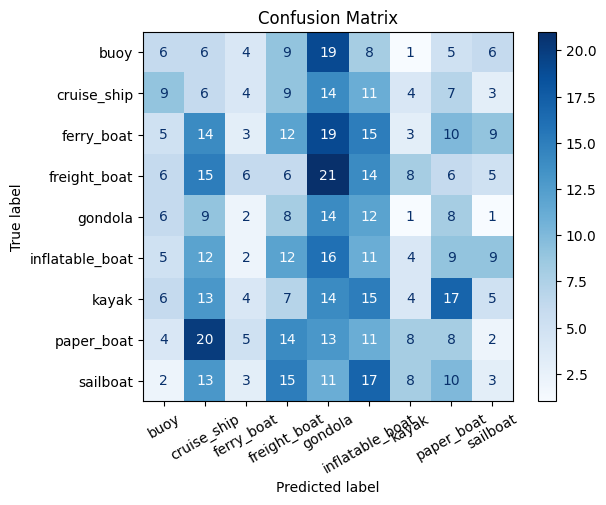

In [51]:
# Call the function to plot confusion matrix
plot_confusion_matrix(cm, class_names)

In [87]:
report_cnn = classification_report(test_data.classes,predicted_labels,target_names=class_names)
print("Classification Report:")
print(report_cnn)

Classification Report:
                 precision    recall  f1-score   support

           buoy       0.12      0.09      0.11        64
    cruise_ship       0.06      0.09      0.07        67
     ferry_boat       0.09      0.03      0.05        90
   freight_boat       0.07      0.07      0.07        87
        gondola       0.10      0.23      0.14        61
inflatable_boat       0.10      0.14      0.11        80
          kayak       0.10      0.05      0.06        85
     paper_boat       0.10      0.09      0.10        85
       sailboat       0.07      0.04      0.05        82

       accuracy                           0.09       701
      macro avg       0.09      0.09      0.08       701
   weighted avg       0.09      0.09      0.08       701



In [52]:
from tensorflow.keras.applications import MobileNetV2

In [53]:
# Load MobileNet model without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

9406464/9406464 [==============================] - 0s 0us/step


In [54]:
from tensorflow.keras.models import Model

In [55]:
# Combine base model with new classification layers
model1 = Model(inputs=base_model.input, outputs=predictions)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [56]:
early_stopping1 = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)


In [57]:
# Train the model
history1 = model1.fit(train_data, epochs=50, validation_data=val_data,callbacks=[early_stopping1])


Epoch 1/50
70/70 [==============================] - 47s 612ms/step - loss: 0.8660 - accuracy: 0.7304 - val_loss: 0.3140 - val_accuracy: 0.9036
Epoch 2/50
70/70 [==============================] - 42s 600ms/step - loss: 0.2518 - accuracy: 0.9232 - val_loss: 0.1887 - val_accuracy: 0.9357
Epoch 3/50
70/70 [==============================] - 42s 598ms/step - loss: 0.2103 - accuracy: 0.9379 - val_loss: 0.2137 - val_accuracy: 0.9304
Epoch 4/50
70/70 [==============================] - 44s 631ms/step - loss: 0.1622 - accuracy: 0.9473 - val_loss: 0.1188 - val_accuracy: 0.9589
Epoch 5/50
70/70 [==============================] - 44s 633ms/step - loss: 0.1132 - accuracy: 0.9612 - val_loss: 0.1145 - val_accuracy: 0.9643
Epoch 6/50
70/70 [==============================] - 44s 623ms/step - loss: 0.0892 - accuracy: 0.9705 - val_loss: 0.0910 - val_accuracy: 0.9768
Epoch 7/50
70/70 [==============================] - 43s 617ms/step - loss: 0.1170 - accuracy: 0.9607 - val_loss: 0.1153 - val_accuracy: 0.9732

In [58]:
# Evaluate on test set
loss, accuracy = model1.evaluate(test_data)
print("Test Accuracy:", accuracy)

22/22 [==============================] - 5s 234ms/step - loss: 0.1866 - accuracy: 0.9444
Test Accuracy: 0.9443652033805847


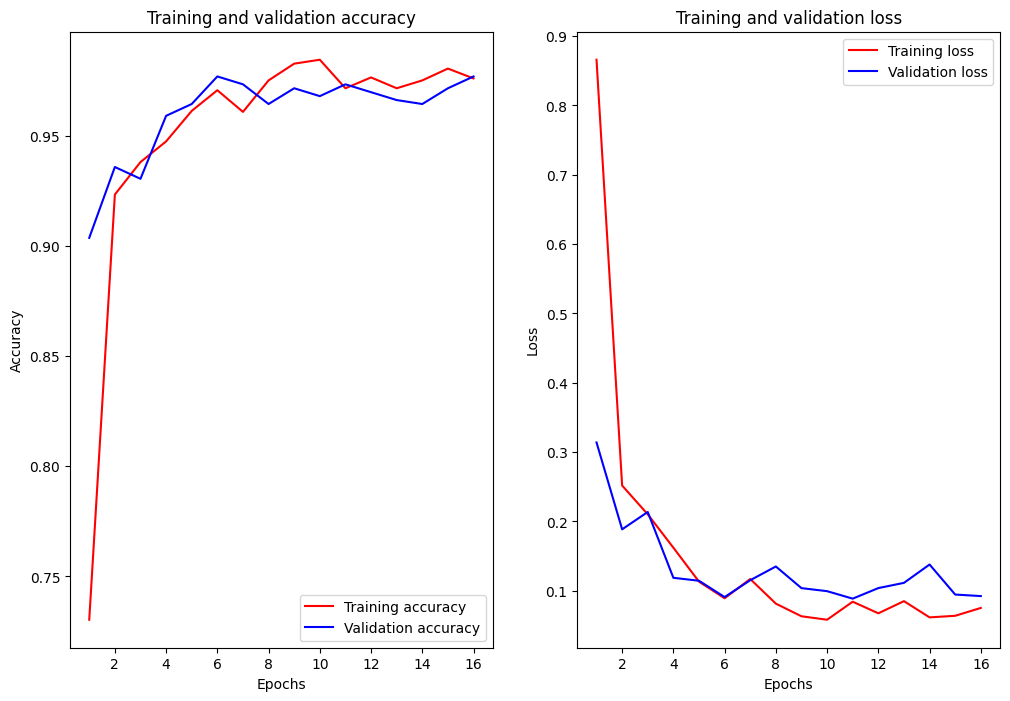

In [59]:
plot_history(history1)

In [60]:
predictions1 = model1.predict(test_data)

22/22 [==============================] - 6s 212ms/step


In [89]:
predicted_labels_mobilenet = np.argmax(predictions1, axis=1)

In [90]:
cm1 = confusion_matrix(test_data.classes,predicted_labels_mobilenet)

<Figure size 1600x800 with 0 Axes>

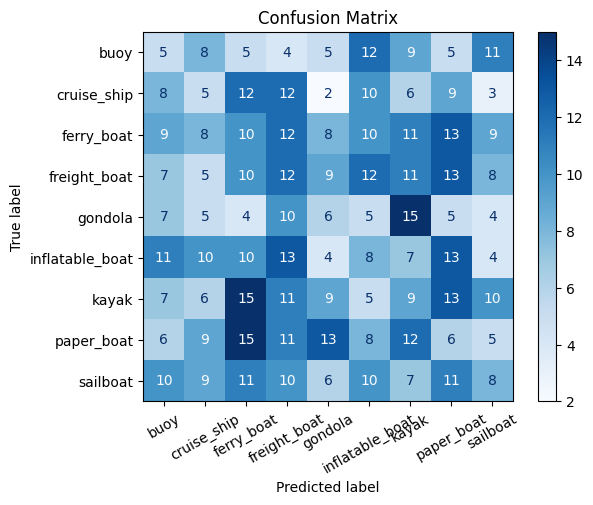

In [91]:
plot_confusion_matrix(cm1, class_names)

In [92]:
report_mobilenet = classification_report(test_data.classes, predicted_labels_mobilenet,target_names=class_names)
print("Classification Report:")
print(report_mobilenet)

Classification Report:
                 precision    recall  f1-score   support

           buoy       0.07      0.08      0.07        64
    cruise_ship       0.08      0.07      0.08        67
     ferry_boat       0.11      0.11      0.11        90
   freight_boat       0.13      0.14      0.13        87
        gondola       0.10      0.10      0.10        61
inflatable_boat       0.10      0.10      0.10        80
          kayak       0.10      0.11      0.10        85
     paper_boat       0.07      0.07      0.07        85
       sailboat       0.13      0.10      0.11        82

       accuracy                           0.10       701
      macro avg       0.10      0.10      0.10       701
   weighted avg       0.10      0.10      0.10       701



In [63]:
img_1 = test_df.iloc[0]['image_path']


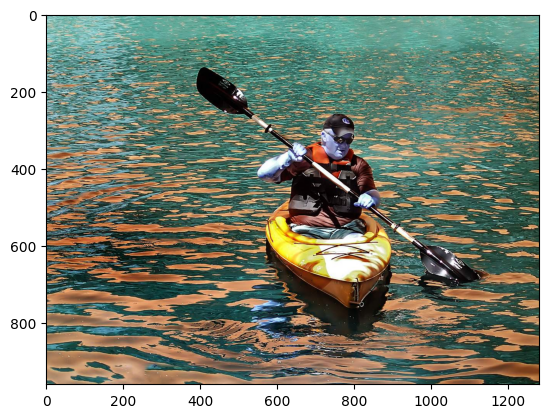

In [64]:
plt.imshow(cv2.imread(img_1))

In [65]:
from tensorflow.keras.applications.mobilenet import preprocess_input, decode_predictions

In [66]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return preprocess_input(img_array)

In [67]:
# Path to the image you want to predict
img_path = '/content1/Automating_Port_Operations_dataset/sailboat/1.jpg'

# Preprocess the image
preprocessed_img = load_and_preprocess_image(img_path)

In [68]:
# Predict using the model
predictions2 = model1.predict(preprocessed_img)

predicted_label = np.argmax(predictions2)
predicted_label

1/1 [==============================] - 1s 1s/step


8

In [69]:
for class_name, class_idx in train_data.class_indices.items():
    if class_idx == predicted_label:
        predicted_class = class_name
        break
print(f'The identified object is : {class_name}')

The identified object is : sailboat


### The object identified by MobilenetV2 is correct
### The Accuracy of the Model mabde by MobilenetV2 Viz model1 gives a value of 95% and also the computation time is less compared to Normal model

In [70]:
predictions3 = model.predict(preprocessed_img)
predicted_label3 = np.argmax(predictions3)
for class_name, class_idx in train_data.class_indices.items():
    if class_idx == predicted_label3:
        predicted_class = class_name
        break
print(f'The identified object is : {class_name}')

1/1 [==============================] - 0s 193ms/step
The identified object is : gondola


### The object identified by normal CNN model is incorrect
### The Accuraccy of thsi model viz 'model' works out to be 54.6%

## MobilenetV2 is a very efficient and accurate image identifier model , THis can be easily loaded and used for varying application
**bold text**

In [71]:
model1.save('mobilnetaphsnr.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('mobilnetaphsnr.tflite', 'wb') as f:
    f.write(tflite_model)
    print("TF Lite model saved successfully.")

TF Lite model saved successfully.


In [73]:
import os

def find_files_with_extension(extension, search_path):
    matches = []
    for root, dirs, files in os.walk(search_path):
        for file in files:
            if file.endswith(extension):
                matches.append(os.path.join(root, file))
    return matches

extension = '.h5'
search_path = '/usr'  # Root directory in Colab
files_found = find_files_with_extension(extension, search_path)

if files_found:
    print("Files found:")
    for file in files_found:
        print(file)
else:
    print("No files found with the extension", extension)

Files found:
/usr/local/lib/python3.10/dist-packages/tables/tests/issue_368.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/zerodim-attrs-1.4.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/float.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/Tables_lzo1_shuffle.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/itemsize.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/python3.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/smpl_unsupptype.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/time-table-vlarray-1_x.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/smpl_SDSextendible.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/flavored_vlarrays-format1.6.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/indexes_2_1.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/non-chunked-table.h5
/usr/local/lib/python3.10/dist-packages/tables/tests/nested-type-with-gaps.h5
/usr/local/lib/python3.10/dist-packages/tables/tes